# Garbage Classification Using Convolutional Neural Networks (CNN)

Authors:
- Arnaud Guzman-Annes
- Jake Hogan
- Sophie Courtemanche-Martel
- Duncan Wang

</br>

For the purposes of this project, the data has been already split into two folders: training and validation. Each of these folders contains sub-folders of the following classes of garbage: glass, paper, cardboard, plastic, metal, trash. Thus, each image within is respective folder has been manually identified, sorted into a folder representing its respective category. Note that all images are stored in and retrieved from our Google Cloud Platform (GCP) bucket.

</br>

## Step 1: Load and Process Images


In this step, we will load images of garbage from the train and test folders and transform the images into array format, which is required for input into the CNN model. Before transforming the images into arrays, we will also introduce some randomness to the process -- such as flipping or cropping the images into various sizes.  This process helps augment the data by increasing the data variety and preventing overfitting on the training dataset. We will store the arrays in lists for later retrieval. 

*Be sure to change runtime type to GPU if on Google Colab*

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import warnings
from google.colab import drive
drive.mount('/content/drive')
MAIN_DIR = '/content/drive/Shareddrives/recycle/first_test/ourdata_v2/' #the main directory of this project

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2: Load Images

*This step may take 3-4 minutes*

In [3]:
#load a single image as a test 
from keras.preprocessing import image
test_image = image.load_img('/content/drive/Shareddrives/recycle/first_test/ourdata_v2/test/paper/IMG_6922.jpg')
test_image

Output hidden; open in https://colab.research.google.com to view.

In [4]:
#load image and transform to 3D array - image array shape is 384 x 512 pixels, colour channels = 3 (RGB)
img_array = image.img_to_array(test_image)
print(img_array.shape)
#process for transforming an image to an array -- one way to do it 
img_array = keras.applications.efficientnet.preprocess_input(img_array)
print(img_array.shape)

(3024, 3024, 3)
(3024, 3024, 3)


#### 1.3: Augment images through random cropping & flipping

In [5]:
#center crop of incoming image, sizing it down to (224, 224, 3)
def center_crop(img):
  image_array = image.img_to_array(img)
  image_array = cv2.resize(image_array, (336,336))
  shape = image_array.shape # H, W, D
  left = int((shape[1]-224)/2)
  right = left + 224
  bottom = int((shape[0]-224)/2)
  top = bottom + 224
  return image_array[bottom:top, left:right]

#random crop of the image within the defined range
def random_crop(img):
  image_array = image.img_to_array(img)
  image_array = cv2.resize(image_array, (336,336))
  shape = image_array.shape
  left = np.random.randint(0, shape[1]-224)
  right = left + 224
  bottom = np.random.randint(0, shape[0]-224)
  top = bottom + 224
  return image_array[bottom:top, left:right]

#with some randomness, either center crop or random crop the image, as well as either flip or do not flip the image.
#隨機翻轉或擷取，且照片被整理為(224,224,3)
def center_process_img(img):
  cropped = center_crop(img)
  if np.random.rand() > 0.5:
    return np.flip(cropped, axis=np.random.randint(0, 2))
  else:
    return cropped
    
def random_process_img(img):
  cropped = random_crop(img)
  if np.random.rand() > 0.5:
    return np.flip(cropped, axis=np.random.randint(0, 2))
  else:
    return cropped


測試Augment images through random cropping & flipping

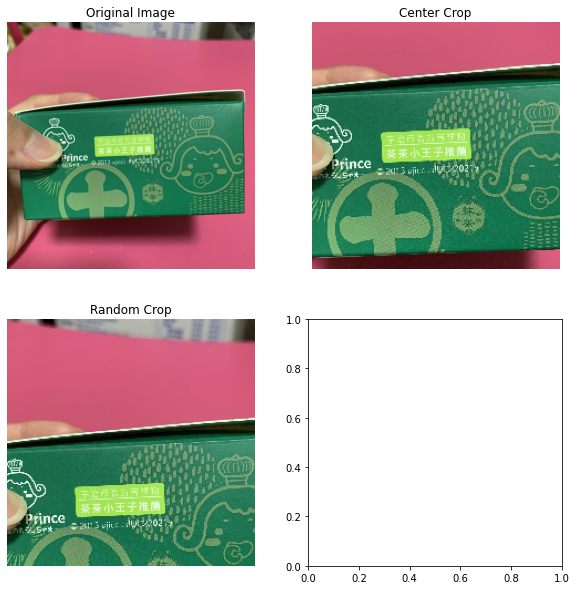

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_image = image.load_img('/content/drive/Shareddrives/recycle/first_test/ourdata_v2/test/paper/IMG_6922.jpg')
center_cropped_test = image.array_to_img(center_crop(test_image))
random_cropped_test = image.array_to_img(random_crop(test_image))
# processed_test = image.array_to_img(keras.applications.efficientnet.preprocess_input(process_img(test_image)))
# print(keras.applications.efficientnet.preprocess_input(process_img(test_image)))

fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)

ax[0, 0].imshow(test_image)
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(center_cropped_test)
ax[0, 1].set_title('Center Crop')
ax[0, 1].axis('off')

ax[1, 0].imshow(random_cropped_test)
ax[1, 0].set_title('Random Crop')
ax[1, 0].axis('off')

# ax[1, 1].imshow(processed_test)
# ax[1, 1].set_title('Full Augmentation')
# ax[1, 1].axis('off')

plt.show()

**Note:** The original image is shape differently because when fed into the models, the image shape is intended to be (224, 224, 3), but the default image is (384, 512, 3).

In [7]:
TEST_PATH = os.path.join(MAIN_DIR, 'test')
VALID_PATH = os.path.join(MAIN_DIR, 'valid')
TRAIN_PATH = os.path.join(MAIN_DIR, 'train')
print(TEST_PATH)
#create lists to write processed images into 
X_test_list = []
y_test_list = []

X_train_list = []
y_train_list = []

X_valid_list = []
y_valid_list = []

folder_names = ['paper', 'can', 'paper_container', 'plastic', 'trash']

#connect to test image folder
#X_test_list的處理
for folder in folder_names:             #folder為資料夾名稱
  FOLDER_PATH = os.path.join(TEST_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(TEST_PATH, folder, im))      #合併(TEST_PATH, folder, im)路徑載入圖片
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preprocess
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (224,224))
    #append processed image to new list
    X_test_list.append(list(ori_resize_img))
    X_test_list.append(list(center_processed_img))
    X_test_list.append(list(random_processed_img))
    #append label of processed image to new list
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來

    if len(y_test_list)%50 == 0:
      print(len(y_test_list), 'images loaded into test')

#connect to train image folder 
#X_train_list的處理
for folder in folder_names:
  FOLDER_PATH = os.path.join(TRAIN_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(TRAIN_PATH, folder, im))
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preproces
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (224,224))
    #append processed image to new list
    X_train_list.append(list(ori_resize_img)) 
    X_train_list.append(list(center_processed_img))
    X_train_list.append(list(random_processed_img))
    #append label of processed image to new list 
    y_train_list += [folder] 
    y_train_list += [folder] 
    y_train_list += [folder] 

    if len(y_train_list)%50 == 0:
      print(len(y_train_list), 'images loaded into train')

for folder in folder_names:             #folder為資料夾名稱
  FOLDER_PATH = os.path.join(VALID_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(VALID_PATH, folder, im))      #合併(VALID_PATH, folder, im)路徑載入圖片
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preprocess
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (224,224))
    #append processed image to new list
    X_valid_list.append(list(ori_resize_img))
    X_valid_list.append(list(center_processed_img))
    X_valid_list.append(list(random_processed_img))
    #append label of processed image to new list
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來

    if len(y_valid_list)%50 == 0:
      print(len(y_valid_list), 'images loaded into valid')

/content/drive/Shareddrives/recycle/first_test/ourdata_v2/test
150 images loaded into test
300 images loaded into test
150 images loaded into train
300 images loaded into train
450 images loaded into train
600 images loaded into train
750 images loaded into train
900 images loaded into train
1050 images loaded into train
1200 images loaded into train
1350 images loaded into train
1500 images loaded into train
150 images loaded into valid
300 images loaded into valid


In [8]:
ori_img = image.img_to_array(img)
img1 = cv2.resize(ori_img, (224,224))
print(img1.shape)

(224, 224, 3)


**Alternative Image Ingestion:** Instead of reading all the images in at once, it's also possible to use an `ImageDataGenerator` which reads images in batches and passes them to the model for training, then frees up memory and repeats with the next batch. This method is helpful for models with high volumes of data, but in our case the set of images was relatively small, so we felt it easier to read all the images in at once, then train the model. 

The `ImageDataGenerator` allows for data augmentation to happen as images are being read in, and the `flow_from_directory` method directs the generator to the source of images.

## Step 3: Preprocess & Split Data

Here, we further clean and split the datasets to prepare the appropriate inputs into the CNN model.

In [9]:
#transform X variables to floats
X_train = np.array(X_train_list).astype(np.float32)
X_test = np.array(X_test_list).astype(np.float32)
X_valid = np.array(X_valid_list).astype(np.float32)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train_list)
print(len(y_train_list))
print(len(y_test_list))
print(len(y_valid_list))

(1533, 224, 224, 3)
(348, 224, 224, 3)
(303, 224, 224, 3)
['paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'pape

In [10]:
y_train = []
for i in range(len(y_train_list)):
  if y_train_list[i] == 'paper':
    y_train.append([1, 0, 0, 0, 0])
  elif y_train_list[i] == 'can':
    y_train.append([0, 1, 0, 0, 0])
  elif y_train_list[i] == 'paper_container':
    y_train.append([0, 0, 1, 0, 0])
  elif y_train_list[i] == 'plastic':
    y_train.append([0, 0, 0, 1, 0])
  elif y_train_list[i] == 'trash':
    y_train.append([0, 0, 0, 0, 1])

y_train = np.array(y_train)
print(y_train)
print(y_train.shape)


y_test = []
for i in range(len(y_test_list)):
  if y_test_list[i] == 'paper':
    y_test.append([1, 0, 0, 0, 0])
  elif y_test_list[i] == 'can':
    y_test.append([0, 1, 0, 0, 0])
  elif y_test_list[i] == 'paper_container':
    y_test.append([0, 0, 1, 0, 0])
  elif y_test_list[i] == 'plastic':
    y_test.append([0, 0, 0, 1, 0])
  elif y_test_list[i] == 'trash':
    y_test.append([0, 0, 0, 0, 1])

y_test = np.array(y_test)
print(y_test)
print(y_test.shape)


y_valid = []
for i in range(len(y_valid_list)):
  if y_valid_list[i] == 'paper':
    y_valid.append([1, 0, 0, 0, 0])
  elif y_valid_list[i] == 'can':
    y_valid.append([0, 1, 0, 0, 0])
  elif y_valid_list[i] == 'paper_container':
    y_valid.append([0, 0, 1, 0, 0])
  elif y_valid_list[i] == 'plastic':
    y_valid.append([0, 0, 0, 1, 0])
  elif y_valid_list[i] == 'trash':
    y_valid.append([0, 0, 0, 0, 1])

y_valid = np.array(y_valid)
print(y_valid)
print(y_valid.shape)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
(1533, 5)
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
(348, 5)
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
(303, 5)


In [11]:
#clear unused variables to save RAM 
X_test_list, X_valid_list, X_train_list, y_test_list, y_valid_list, y_train_list = [], [], [], [], [], []

## Step 4: Build CNN Model

#### 4.1 Transfer Learning: Create a Base Pre-Trained Model

Here, we import a pre-trained model to use as the base model of our CNN network. Known as transfer learning, this is beneficial since our dataset may not have enough images of garbage to train a full-fledged model off of. In this case, we can take features learned from a pre-trained model and apply them to identify types of garbage, so that our model does not have to start learning from scratch. Since we do not have a pre-trained garbage-classifier specifically, we use the "ImageNet" model instead, which is trained on a large collection of different items and could be useful for identifying garbage items.


In short, transfer learning allows us to: 

1. Instantiate a base model and load pre-trained weights onto it
2. Freeze all layers in the base model and create a new model on top
3. Train the new model on our garbage dataset.

In [12]:
base_model = keras.applications.EfficientNetB4(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

71696384/71686520 [==============================] - 1s 0us/step


#### 4.2: Build a CNN

Here, we create a Sequential model and add our pre-trained ImageNet model, as well as several other layers.

In [13]:
#freeze the base model 
base_model.trainable = False

#define the type of NN architecture - sequential model specifies a linear stack of layers 
model = keras.models.Sequential()

#add the pre-trained model
model.add(base_model)

#pool layer to prepare data as input into dense layer 
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
#batch normalization layer re-centers and re-scales the network - helps accelerate training
model.add(keras.layers.BatchNormalization())
#dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
model.add(keras.layers.Dropout(0.2))
#flatten layer to single array for input into dense layer 
model.add(keras.layers.Flatten())
# prediction layer - 6 neurons = 6 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
model.add(keras.layers.Dense(5, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 flatten (Flatten)           (None, 256)               0

In [15]:
#compile model, specify sparse categorical crossentropy for classification and evaluate accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 4.3: Implement Custom Callback functions 

Here, we implement two custom callback functions to use when training the model. The first callback creates a custom function which stops training if training accuracy is over 0.999, to prevent overfitting. The second callback logs model statistics which we can view later on to review the training progress.

In [16]:
# implementing a custom callback to stop training if we reach accuracy >0.999 because that indicates overfitting on this relatively small dataset
class OverfittingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      self.model.stop_training = True
      print('Trying to prevent overfitting - stopping training')

In [17]:
#TensorBoard - log model statistics
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
  import time
  run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_callback = keras.callbacks.TensorBoard(run_logdir, update_freq="epoch")

## Step 5: Train Model

We first train the model for 40 epochs (or until custom callback stop is activated) with the base model layers frozen. After the model has converged on the new data, we can unfreeze the base model and retrain with the unfrozen base model layers.

This is important since if the randomly-initialized trainable layers are mixed with the with trainable layers from the base model that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy the pre-trained features from the base model. 

In [18]:
#train model for 40 epochs 
history = model.fit(X_train, y_train, epochs=40, validation_data = (X_valid, y_valid), callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), OverfittingCallback(), tensorboard_callback])

Epoch 1/40
48/48 [==============================] - 35s 277ms/step - loss: 0.5122 - accuracy: 0.7482 - val_loss: 0.4417 - val_accuracy: 0.7558
Epoch 2/40
48/48 [==============================] - 10s 205ms/step - loss: 0.2382 - accuracy: 0.9315 - val_loss: 0.3418 - val_accuracy: 0.7954
Epoch 3/40
48/48 [==============================] - 9s 179ms/step - loss: 0.1453 - accuracy: 0.9687 - val_loss: 0.2682 - val_accuracy: 0.8152
Epoch 4/40
48/48 [==============================] - 10s 205ms/step - loss: 0.0983 - accuracy: 0.9765 - val_loss: 0.2421 - val_accuracy: 0.8053
Epoch 5/40
48/48 [==============================] - 10s 208ms/step - loss: 0.0671 - accuracy: 0.9843 - val_loss: 0.2141 - val_accuracy: 0.8152
Epoch 6/40
48/48 [==============================] - 10s 208ms/step - loss: 0.0484 - accuracy: 0.9935 - val_loss: 0.2025 - val_accuracy: 0.8251
Epoch 7/40
48/48 [==============================] - 10s 209ms/step - loss: 0.0400 - accuracy: 0.9954 - val_loss: 0.2053 - val_accuracy: 0.8152


In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.21685795485973358 / Test accuracy: 0.8103448152542114


In [20]:
#unfreeze base model 
base_model.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 flatten (Flatten)           (None, 256)               0

In [21]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'), OverfittingCallback()])

Epoch 1/40
48/48 [==============================] - 9s 184ms/step - loss: 0.0192 - accuracy: 0.9980 - val_loss: 0.2169 - val_accuracy: 0.8185
Epoch 2/40
48/48 [==============================] - 9s 183ms/step - loss: 0.0176 - accuracy: 0.9980 - val_loss: 0.2147 - val_accuracy: 0.8086
Epoch 3/40
48/48 [==============================] - 9s 184ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.2304 - val_accuracy: 0.8020


## Step 6: Generate Predictions & View Model Results

####6.1: View Incorrect Predictions
First, let's look at the predictions that were classified incorrectly. 


In [22]:
incorrect = dict()
x = np.where(y_test[0] == 1)[0][0]
print(len(X_test))
for idx, predictions in enumerate(model.predict(X_test)):       #predictions為各分類機率的陣列
  print(idx, predictions)
  if np.argmax(predictions) != np.where(y_test[idx] == 1)[0][0]:
    incorrect[idx] = {'Predicted': np.argmax(predictions), 'Actual': y_test[idx][0]}

incorrect_preds = pd.DataFrame.from_dict(incorrect, orient='index')

348
0 [7.8369153e-01 2.9355695e-04 3.6791727e-01 1.7586873e-03 1.6883746e-04]
1 [9.5713657e-01 6.3471054e-03 6.2145153e-03 7.3212571e-03 8.5600221e-04]
2 [0.26486596 0.00456629 0.01044951 0.40733063 0.00133782]
3 [0.9619007  0.00268626 0.02896088 0.01021059 0.01763976]
4 [0.7553275  0.00608312 0.28246352 0.00146781 0.01310121]
5 [0.22191793 0.00453522 0.6208845  0.0016668  0.00854906]
6 [9.9991453e-01 2.9998875e-04 2.1499571e-04 5.1986944e-04 4.2949324e-03]
7 [9.9992812e-01 8.8338209e-05 2.7687498e-04 3.0231642e-04 6.2697809e-03]
8 [9.9989533e-01 1.1759144e-04 2.6510565e-03 5.0470646e-04 6.7074839e-03]
9 [0.9885815  0.00113214 0.02799324 0.003509   0.00228025]
10 [9.9863476e-01 7.4890495e-04 4.6564679e-04 4.2336420e-04 2.3390017e-03]
11 [9.9355376e-01 1.6531266e-03 1.2198095e-03 3.1250855e-04 1.7731147e-03]
12 [0.06138236 0.00694939 0.05072    0.00092164 0.00776076]
13 [9.7056478e-01 4.6105194e-03 3.3713412e-01 8.5977878e-04 2.6246745e-03]
14 [9.7384429e-01 1.7662999e-03 5.8199870e-03 

In [23]:
incorrect_preds.reset_index()

,index,Predicted,Actual
0,2,3,1
1,5,2,1
2,24,2,1
3,25,2,1
4,26,2,1
5,27,2,1
6,28,2,1
7,42,2,1
8,43,3,1
9,44,2,1



####6.2: Visualize Predictions 
Since the CNN classifier is only capable of generating numerical predictions from 0-5, we can now generate predictions and then assign them back to their associated garbage class. After doing so, we can plot each image, its true label, and compare this to the predicted label.

In [24]:
#generate predictions using the test dataset
predicted_class=np.argmax(model.predict(X_test), axis = -1)
predicted_class
print(predicted_class)

[0 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 3 2 0 0 0 4 2 4 0 0 0 0 0 0 0 0 0 1 1 3 1 1 1 1 1 1 1 3 1 1 1
 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 3 2 2 3 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 0 0 0 2 2 2 0 0 2 2
 2 2 2 2 4 3 0 2 0 0 2 2 2 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 4 3 3 3 1 1 3 3 3 3
 3 3 3 3 3 3 3 3 1 0 0 4 4 4 4 4 4 4 0 2 4 4 4 3 3 3 4 4 4 4 4 4 4 4 4 4 3
 4 4 4 4 4 2 4 4 4 4 4 4 4 1 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 3 4 4 4 4 4]


In [25]:
#convert the predicted and actual test values back to their associated labels
def class_convert_x(classess):
    pred=[]
    for i in classess:
        if i ==0:
            pred.append('paper')
        elif i==1:
            pred.append('can')
        elif i==2:
            pred.append('paper_container')
        elif i==3:
            pred.append('Plastic')
        elif i==4:
            pred.append('Trash')
    return pred


def class_convert_y(classess):
    pred=[]
    for i in classess:
        if i[0]==1:
            pred.append('paper')
        elif i[1]==1:
            pred.append('can')
        elif i[2]==1:
            pred.append('paper_container')
        elif i[3]==1:
            pred.append('Plastic')
        elif i[4]==1:
            pred.append('Trash')
    return pred

pred_class=class_convert_x(predicted_class)   #_x_test的預測結果
print(pred_class)
y_class=class_convert_y(y_test)         #y為答案
print(y_class)
print(len(pred_class), len(y_class))

['paper', 'paper', 'Plastic', 'paper', 'paper', 'paper_container', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper_container', 'paper_container', 'paper_container', 'paper_container', 'paper_container', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper_container', 'Plastic', 'paper_container', 'paper', 'paper', 'paper', 'Trash', 'paper_container', 'Trash', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'can', 'can', 'Plastic', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'Plastic', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'paper_container', 'Plastic', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'Plastic', 'can', 'can', '

####6.3: Evaluate Correct vs. Incorrect Predictions

In [26]:
corr=0
false=0
for i in range(len(y_class)):
    if y_class[i]==pred_class[i]:
         corr=corr+1
    else:
        false=false+1
        
print("Correct:",corr)
print("False",false)
print(corr/(corr+false))

Correct: 292
False 56
0.8390804597701149


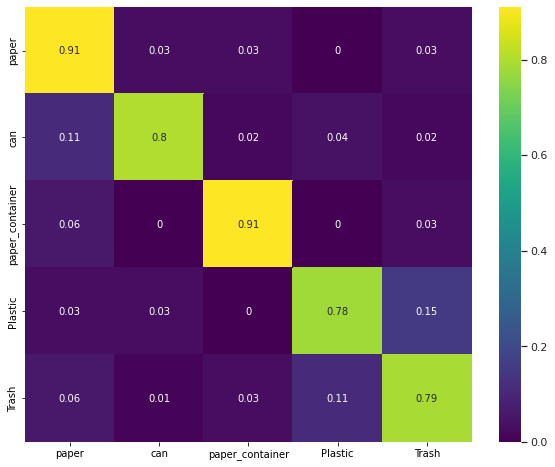

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)
cm=confusion_matrix(y_class,pred_class)

array_list = []
for i in range(5):
  sum_row = np.sum(cm[i])
  ratio_row = np.around(cm[i]/sum_row, decimals=2)
  array_list.append(ratio_row)
cm = np.array(array_list)

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['paper','can','paper_container','Plastic', 'Trash']
df_cm.index = ['paper','can','paper_container','Plastic', 'Trash']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis") # font size
plt.show()

## Step 7: Input Your Own Data & Generate Prediction

Here, we input a photo we took ourselves, and test our model's performance on it. We can see that the model correctly classified paper post-it that we uploaded. Success!! 


In [ ]:
# import io.capture_output
# if not os.path.exists('/content/garbage_classifier/test_images'):
#   os.mkdir('/content/garbage_classifier/test_images')

# os.chdir(os.path.join(MAIN_DIR, 'test_images'))
# with io.capture_output() as captured:
#   !wget https://storage.googleapis.com/ai-project-315815-bucket/garbage_images/external_test_images/metal_test.jpeg
#   !wget https://storage.googleapis.com/ai-project-315815-bucket/garbage_images/external_test_images/paper_test.jpeg

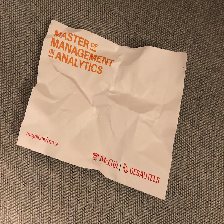

In [29]:
image_path = '/content/drive/Shareddrives/recycle/test_images/paper_test.jpeg'
image.load_img(image_path, target_size=(224, 224))

In [30]:
def classify_image(my_image):
  custom_image = image.load_img(my_image, target_size=(224, 224))
  img_array = image.img_to_array(custom_image)
  processed_img = keras.applications.efficientnet.preprocess_input(img_array).astype(np.float32)
  swapped = np.moveaxis(processed_img, 0,1)
  arr4d = np.expand_dims(swapped, 0)
  new_prediction= class_convert_x(np.argmax(model.predict(arr4d), axis = -1))   #用class_convert進行文字分類
  value = model.predict(arr4d)
  print(new_prediction)
  print(value)
  print('Your item is: ', new_prediction[0])

In [31]:
classify_image('/content/drive/Shareddrives/recycle/test_images/paper_test.jpeg')

['Trash']
[[1.5608039e-02 2.1142701e-03 1.6787794e-03 3.5806827e-04 9.9965560e-01]]
Your item is:  Trash


In [32]:
model.save("/content/drive/Shareddrives/recycle/first_test/my_model_v4.h5/")

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/recycle/first_test/my_model_v4.h5/assets
